# Premier League with WebScraping and Clustering

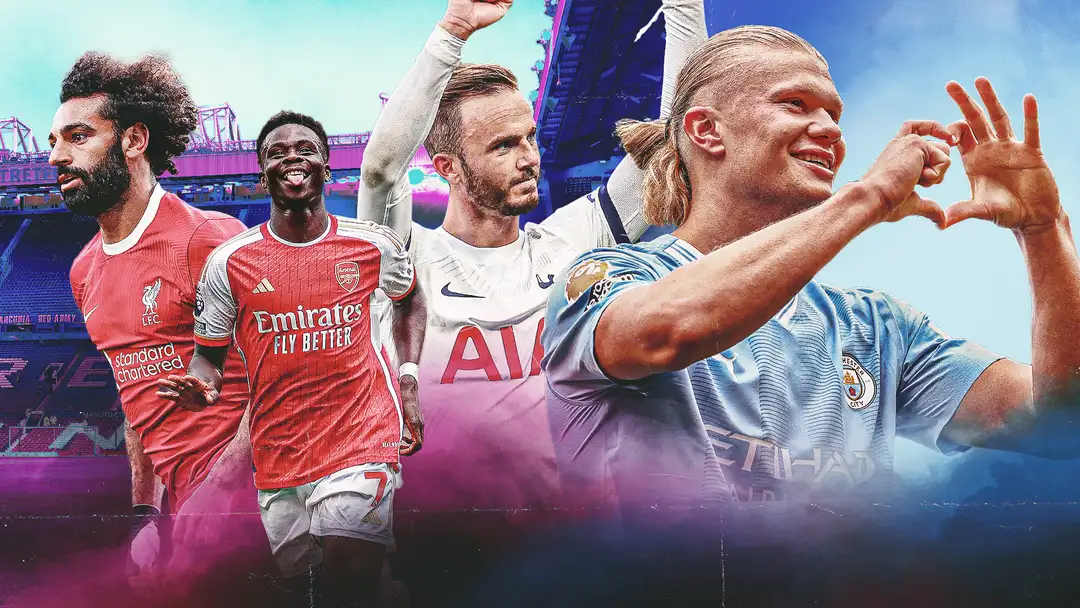

The Premier League is the highest level of the England football. 20 teams play each season. The seasons typically run from August to May with each team playing 38 matches (playing all other teams both home and away)

The Premier League is the most-watched sports league in the world, broadcast in 212 territories to 643 million homes

The idea of this project is using WebScraping to get the data, and then apply clustering in order to find similarities and differencies among the players.

The data is from the season 2022/2023. We have data related to the teams, and data related to the players.

About the data related to the players, we have four kind of stats:
* Summary: Contains general stats of the players.
* Offensive: Contains stats related to the attack.
* Passing: Contains stats related to the passes
* Deffensive: Contains stats related to the deffense.

The data is from https://www.kickest.it/en/premier-league.

## Import Libreries

In [1]:
from selenium.webdriver import Firefox
from selenium.webdriver.firefox.options import Options
from selenium.common.exceptions import NoSuchElementException, StaleElementReferenceException
from time import sleep
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import plotly.express as px

!pip install kneed
from kneed import KneeLocator

## Web Scrapping

Before starting I define some methods.

I have these methods to close some pop ups that are shown when the page is loaded.

In [16]:
def close_advertisement(page):
    """ 
    Close adersisement popup
    
    Parameters
    ----------
    page : selenium page
    """
    try:
        adv = page.find_element_by_id("dugout-clsbtn")
        adv.click()
    except NoSuchElementException:
        None
        
def close_cookies(browser):
    """ 
    Close popup related to the cookies
    
    Parameters
    ----------
    browser : selenium driver
    """
    try:
        browser.find_element_by_css_selector('button[mode="primary"]').click()
    except NoSuchElementException:
        None

def close_pop_up(browser):
    """ 
    Close popup related to subscription
    
    Parameters
    ----------
    browser : selenium driver
    """
    try:
        browser.find_element_by_css_selector('.webpush-swal2-close').click()
    except NoSuchElementException:
        None

First at all, let's extract the data related to the teams.

### Teams

#### Extract

In [424]:
def get_teams_data_frame():
    """ 
    Extract the data related to the teams and returns a dataframe with all the information
    """
    site_url = 'https://www.whoscored.com/Regions/252/Tournaments/2/Seasons/9075/Stages/20934/TeamStatistics/England-Premier-League-2022-2023'
    browser = Firefox()
    browser.implicitly_wait(5)
    browser.get(site_url)
    close_cookies(browser)
    close_pop_up(browser)}
    sleep(5)

    table = browser.find_element_by_id('top-team-stats-summary-grid')
    close_advertisement(table)
    
    #Table header
    columns_name = []
    header = table.find_element_by_tag_name("thead")
    header_tr = header.find_elements_by_tag_name("tr")
    for header_row in header_tr:
        for header_column in header_row.find_elements_by_tag_name('th'):
            columns_name.append(header_column.text)

    #Table body
    body = table.find_element_by_id('top-team-stats-summary-content')            
    body_tr = body.find_elements_by_tag_name("tr")
    dataframe_body = []
    dataframe_row = []

    for row in body_tr:
        dataframe_row = []
        index = 0
        for column in row.find_elements_by_tag_name('td'):
            if index == 3:
                y = column.find_element_by_css_selector('.yellow-card-box')
                r = column.find_element_by_css_selector('.red-card-box')
                dataframe_row.append(y.text+'-'+r.text)
                index=index+1
            else:
                dataframe_row.append(column.text)
                index=index+1
        dataframe_body.append(dataframe_row)
    
    df = pd.DataFrame(dataframe_body, columns=columns_name)
    return df

In [425]:
df_teams = get_teams_data_frame()

In [428]:
df_teams.head(3)

,Team,Goals,Shots pg,Discipline,Possession%,Pass%,AerialsWon,Rating
0,1. Manchester City,94,15.8,44-1,65.2,89.2,11.6,6.90
1,2. Arsenal,88,15.6,52-0,59.7,85.4,12.9,6.81
2,3. Newcastle,68,15,62-1,52.2,79.8,14.7,6.79


I will do a bit of preprocessing to extract the position, team's name, yellow and red cards.

#### Transform

In [429]:
def extract_team_data(df):
    """ 
    Extract the position and the name of the team from Team feature and create new columns.
    Extract yellow and red cards and create new columns.
    
    Return the data frame with the new four columns: position, team, yellow_cards and red_cards
    """
    df['position'] = df["Team"].split(".")[0]
    df['team'] = df["Team"].split(".")[1]
    df['yellow_cards'] = df["Discipline"].split("-")[0]
    df['red_cards'] = df["Discipline"].split("-")[1]
    return df

df_teams = df_teams.apply(extract_team_data, axis=1)
df_teams

,Team,Goals,Shots pg,Discipline,Possession%,Pass%,AerialsWon,Rating,position,team,yellow_cards,red_cards
0,1. Manchester City,94,15.8,44-1,65.2,89.2,11.6,6.90,1,Manchester City,44,1
1,2. Arsenal,88,15.6,52-0,59.7,85.4,12.9,6.81,2,Arsenal,52,0
2,3. Newcastle,68,15,62-1,52.2,79.8,14.7,6.79,3,Newcastle,62,1
3,4. Manchester United,58,15.6,78-2,53.8,82.3,12.3,6.77,4,Manchester United,78,2
4,5. Liverpool,75,15.9,57-1,60.6,84.2,12.7,6.75,5,Liverpool,57,1
5,6. Brighton,72,16.1,59-0,60.5,85.9,11.7,6.72,6,Brighton,59,0
6,7. Tottenham,70,13.6,75-3,49.8,83.4,14.6,6.71,7,Tottenham,75,3
7,8. Brentford,58,10.7,55-1,43.3,74.8,17.6,6.67,8,Brentford,55,1
8,9. Aston Villa,51,11.3,80-1,49.2,81.1,11.7,6.65,9,Aston Villa,80,1
9,10. Chelsea,38,12.7,77-3,58.8,85.8,13.1,6.62,10,Chelsea,77,3


In [439]:
# Removes unnecessary columns
df_teams = df_teams.copy()
df_teams = df_teams.drop(['Discipline', 'Team'], axis=1)

# Rename columns
df_teams.rename(columns={'Goals':'goals', 'Shots pg':'shots', 'Possession%':'possession_percentage',
                'AerialsWon':'aerials_won', 'Rating':'rating', 'Pass%':'pass_succ_percentage'}, 
           inplace=True)

# Reorder columns
df_teams = df_teams[['position', 'team', 'goals', 'shots', 'possession_percentage', 
            'pass_succ_percentage', 'yellow_cards', 'red_cards', 'aerials_won', 'rating']]

df_teams.head(3)

,position,team,goals,shots,possesion_percentage,pass_succ_percentage,yellow_cards,red_cards,aerials_won,rating
0,1,Manchester City,94,15.8,65.2,89.2,44,1,11.6,6.90
1,2,Arsenal,88,15.6,59.7,85.4,52,0,12.9,6.81
2,3,Newcastle,68,15,52.2,79.8,62,1,14.7,6.79


I set the expected type to each feature.

In [440]:
df_teams["position"] = pd.to_numeric(df_teams["position"])
df_teams["goals"] = pd.to_numeric(df_teams["goals"])
df_teams["shots"] = pd.to_numeric(df_teams["shots"])
df_teams["possession_percentage"] = pd.to_numeric(df_teams["possession_percentage"])
df_teams["pass_succ_percentage"] = pd.to_numeric(df_teams["pass_succ_percentage"])
df_teams["yellow_cards"] = pd.to_numeric(df_teams["yellow_cards"])
df_teams["red_cards"] = pd.to_numeric(df_teams["red_cards"])
df_teams["aerials_won"] = pd.to_numeric(df_teams["aerials_won"])
df_teams["rating"] = pd.to_numeric(df_teams["rating"])

In [441]:
df_teams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   position              20 non-null     int64  
 1   team                  20 non-null     object 
 2   goals                 20 non-null     int64  
 3   shots                 20 non-null     float64
 4   possesion_percentage  20 non-null     float64
 5   pass_succ_percentage  20 non-null     float64
 6   yellow_cards          20 non-null     int64  
 7   red_cards             20 non-null     int64  
 8   aerials_won           20 non-null     float64
 9   rating                20 non-null     float64
dtypes: float64(5), int64(4), object(1)
memory usage: 1.7+ KB


We have 20 teams and 10 features
For summary data we have these features:
* **position**: Position of the team in the end of the league.
* **team**: Name of the team.
* **goals**: Total goals.
* **shots**: Shots per game.
* **possesion_percentage**: Percentage of possesion.
* **pass_succ_percentage**: Percentage of passes success.
* **yellow_cards**: Total number of yellow cards.
* **red_cards**: Total number of red cards.
* **aerials_won**: Aerial duels won per game.
* **rating**: Rating of the team.

Now that I have the data ready, I store it.

In [443]:
df_teams.to_csv('premier_2223_teams_summary.csv')

#### Team analysis

Before analysing the players, let's take a quick look at the teams.

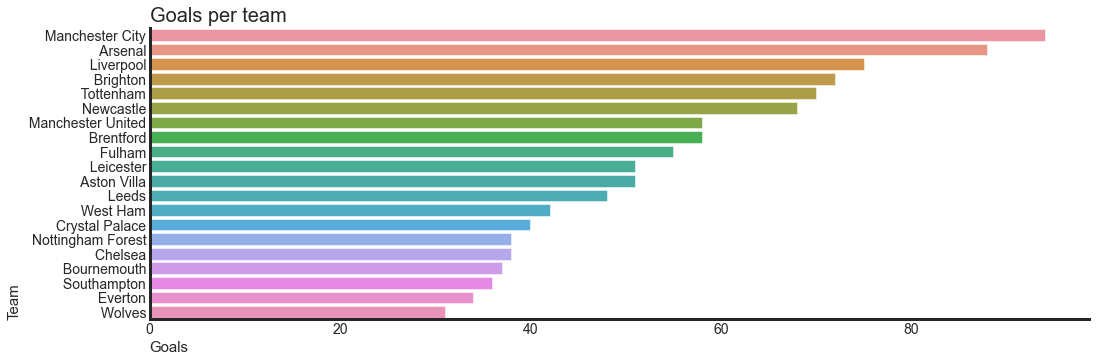

In [467]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(15, 5))
teams_goals_plot = sns.barplot(data=df_teams.sort_values('goals', ascending=False), y="team", 
                               x="goals", ax=ax)
teams_goals_plot.set_ylabel('Team', loc="bottom", fontsize=15)
teams_goals_plot.set_xlabel('Goals', loc="left", fontsize=15)
teams_goals_plot.set_title('Goals per team', loc="left", fontsize=20)
sns.despine()

Manchester City is the team with the most number of goals, followed by Arsenal. Manchester City has won the league in this season.

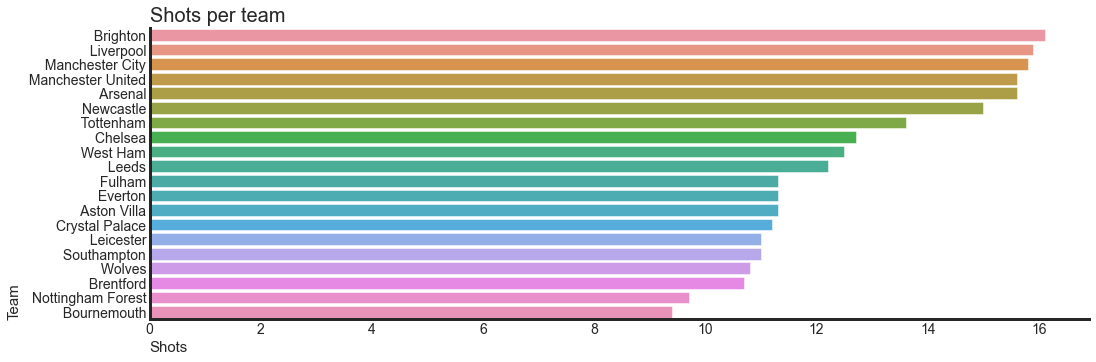

In [468]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(15, 5))
teams_shots_plot = sns.barplot(data=df_teams.sort_values('shots', ascending=False), y="team", 
                               x="shots", ax=ax)
teams_shots_plot.set_ylabel('Team', loc="bottom", fontsize=15)
teams_shots_plot.set_xlabel('Shots', loc="left", fontsize=15)
teams_shots_plot.set_title('Shots per team', loc="left", fontsize=20)
sns.despine()

We can see how the Manchester City is the team with most number of goals, but it is the third team with most number of shots per match. Brighton is the team with more shots per match.

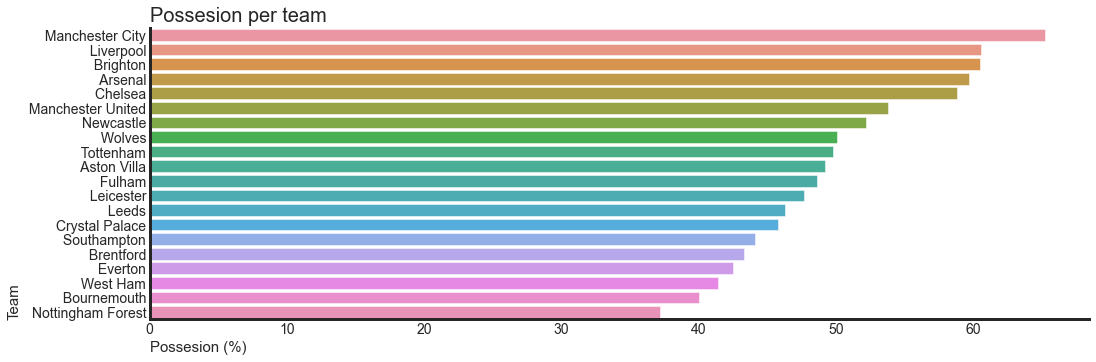

In [470]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(15, 5))
teams_possesion_percentage_plot = sns.barplot(data=df_teams.sort_values('possession_percentage', 
                              ascending=False), y="team", x="possession_percentage", ax=ax)
teams_possesion_percentage_plot.set_ylabel('Team', loc="bottom", fontsize=15)
teams_possesion_percentage_plot.set_xlabel('Possession (%)', loc="left", fontsize=15)
teams_possesion_percentage_plot.set_title('Possession per team', loc="left", fontsize=20)
sns.despine()

With high difference Manchester City is the team with the best percentage of possession with 65.2% and Nottingham Forest has the lowest percentage with 37.2%

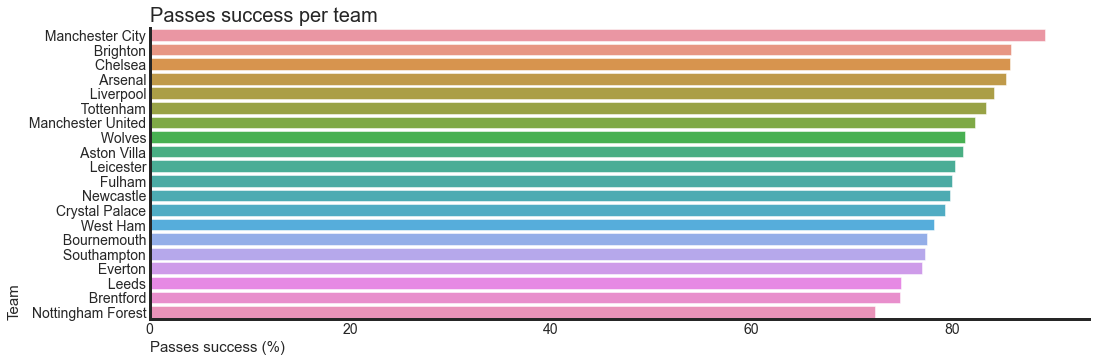

In [471]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(15, 5))
teams_pass_succ_percentage_plot = sns.barplot(data=df_teams.sort_values('pass_succ_percentage', 
                              ascending=False), y="team", x="pass_succ_percentage", ax=ax)
teams_pass_succ_percentage_plot.set_ylabel('Team', loc="bottom", fontsize=15)
teams_pass_succ_percentage_plot.set_xlabel('Passes success (%)', loc="left", fontsize=15)
teams_pass_succ_percentage_plot.set_title('Passes success per team', loc="left", fontsize=20)
sns.despine()

Here we can see how the Manchester City stands out too. This explains how the team reaches the possession.

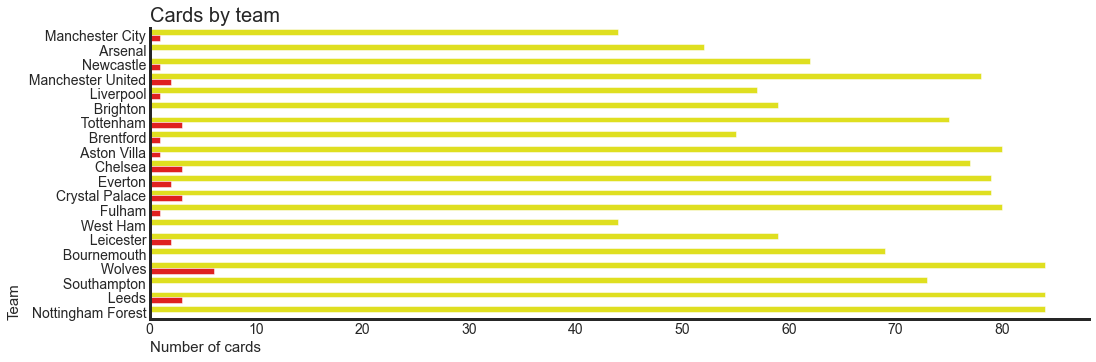

In [499]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(15, 5))
df_cards = df_teams[['yellow_cards','red_cards','team']]
df_cards = pd.melt(df_cards, id_vars='team', var_name='cards', value_name='count_cards')
colors = {'yellow_cards': 'yellow', 'red_cards': 'red'}

teams_cards_plot = sns.barplot(data=df_cards,y='team', x='count_cards', hue='cards', palette=colors, 
                               ax=ax)
teams_cards_plot.set_ylabel('Team', loc="bottom", fontsize=15)
teams_cards_plot.set_xlabel('Number of cards', loc="left", fontsize=15)
teams_cards_plot.set_title('Cards by team', loc="left", fontsize=20)
teams_cards_plot.legend().set_visible(False)
sns.despine()

Manchester City is one the teams with less number of yellow cards. Leeds and Nottingham Forest have the most number of yellow cards (this could explain the low possession).

About the red cards, there are just six teams with zero cards. 

### Players

Now that we have taken a look at the teams. We can start with the players.

#### Extract

I defined a method to extract the data based on the stat type (Summary, Defensive, Offensive, Passing).

In [17]:
def get_players_data_frame(stats_type):
    """ 
    Extract the data related to the players and returns a dataframe with all the information
    Parameters
    ----------
    stats_type : kind of stats to be extracted(summary, defensive, offensive, passing)
    """
    
    site_url = 'https://www.whoscored.com/Regions/252/Tournaments/2/Seasons/9075/Stages/20934/PlayerStatistics/England-Premier-League-2022-2023'
    browser = Firefox()
    browser.implicitly_wait(5)
    browser.get(site_url)
    close_cookies(browser)
    close_pop_up(browser)
    
    #select the expected tab
    if stats_type == "summary":
        browser.find_element_by_id('stage-top-player-stats-options').find_elements_by_tag_name("li")[0].click()
    elif stats_type == "defensive":
        browser.find_element_by_id('stage-top-player-stats-options').find_elements_by_tag_name("li")[1].click()
    elif stats_type == "offensive":
        browser.find_element_by_id('stage-top-player-stats-options').find_elements_by_tag_name("li")[2].click()
    elif stats_type == "passing":
        browser.find_element_by_id('stage-top-player-stats-options').find_elements_by_tag_name("li")[3].click()
    else:
        raise Exception("Stat type not supported")
    sleep(5)

    filterData = browser.find_element_by_id('statistics-mini-filter-' + stats_type)
    filterData.find_element_by_id("apps").find_elements_by_tag_name("dd")[1].click()
    
    table = browser.find_element_by_id('statistics-table-' + stats_type)
    page = table.find_element_by_id('top-player-stats-summary-grid')
    close_advertisement(page)
    
    #Header
    columns_name = []
    header = page.find_element_by_id("player-table-statistics-head")
    header_tr = header.find_elements_by_tag_name("tr")
    for header_row in header_tr:
        for header_column in header_row.find_elements_by_tag_name('th'):
            columns_name.append(header_column.text)

    #Body
    continue_loop = True
    dataframe_body = []
    dataframe_row = []
    while continue_loop:
        try:
            table = browser.find_element_by_id('statistics-table-' + stats_type)
            page = table.find_element_by_id('top-player-stats-summary-grid')            
            close_advertisement(page)
            body = page.find_element_by_id("player-table-statistics-body")
            body_tr = body.find_elements_by_tag_name("tr")
            for row in body_tr:
                dataframe_row = []
                for column in row.find_elements_by_tag_name('td'):
                    dataframe_row.append(column.text)
                dataframe_body.append(dataframe_row)

            pagination_section = browser.find_element_by_id('statistics-paging-' + stats_type)
            next_button = pagination_section.find_element_by_id('next')
            if 'clickable' in next_button.get_attribute("class"):
                next_button.click()
            else:
                continue_loop = False

        except (StaleElementReferenceException, NoSuchElementException) as ex:
            pass
    
    df = pd.DataFrame(dataframe_body, columns=columns_name)
    return df

In [147]:
df_summary = get_players_data_frame("summary")

In [199]:
df_offensive = get_players_data_frame("offensive")

In [210]:
df_defensive = get_players_data_frame("defensive")

In [211]:
df_passing = get_players_data_frame("passing")

In [148]:
df_summary

,Player,,Apps,Mins,Goals,Assists,Yel,Red,SpG,PS%,AerialsWon,MotM,Rating
0,"1\nAsmir Begovic\nEverton, 36, GK",,1,90,-,-,-,-,-,64,1,1,7.82
1,"2\nKevin De Bruyne\nMan City, 32, M(CLR),FW",,28(4),2425,7,16,1,-,2,80.8,0.4,9,7.58
2,"3\nStefan Ortega\nMan City, 31, GK",,3,270,-,-,-,-,-,85.4,0.3,1,7.56
3,"4\nErling Haaland\nMan City, 23, FW",,33(2),2779,36,8,5,-,3.5,74.8,1.4,6,7.54
4,"5\nHarry Kane\nTottenham, 30, AM(C),FW",,38,3408,30,3,6,-,3.4,72,1.7,8,7.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,"565\nDexter Lembikisa\nWolves, 20, D(R)",,0(1),22,-,-,-,-,-,81.8,-,-,5.88
565,"566\nCameron Peupion\nBrighton, 21, Midfielder",,0(1),5,-,-,-,-,1,75,1,-,5.85
566,"567\nAndrew Moran\nBrighton, 20, Midfielder",,0(1),11,-,-,-,-,-,50,-,-,5.83
567,"568\nShane Duffy\nFulham, 31, D(C)",,0(5),17,-,-,-,-,0.2,80,0.4,-,5.79


Now we have a dataframe for each kind of stats. I will store the data just to avoid the WebScrapping again.

In [195]:
df_summary.to_csv("premier_2223_players_summary.csv")
df_offensive.to_csv("premier_2223_players_offensive.csv")
df_defensive.to_csv("premier_2223_players_defensive.csv")
df_passing.to_csv("premier_2223_players_passing.csv")

Now we have the data for each kind of stats, I will transform each of them.

#### Transform

##### Summary data

In [9]:
df_summary.head(5)

,Player,,Apps,Mins,Goals,Assists,Yel,Red,SpG,PS%,AerialsWon,MotM,Rating
0,"1\nKevin De Bruyne\nMan City, 32, M(CLR),FW",,28(4),2425,7,16,1,-,2,80.8,0.4,9,7.58
1,"2\nErling Haaland\nMan City, 23, FW",,33(2),2779,36,8,5,-,3.5,74.8,1.4,6,7.54
2,"3\nHarry Kane\nTottenham, 30, AM(C),FW",,38,3408,30,3,6,-,3.4,72,1.7,8,7.51
3,"4\nBruno Fernandes\nMan Utd, 29, M(CLR)",,37,3320,8,8,6,-,2.5,77.7,0.5,6,7.44
4,"5\nGabriel Jesus\nArsenal, 26, AM(LR),FW",,24(2),2075,11,6,6,-,3,81.5,1.7,4,7.42


In the column **Player** we have a lot of information, such as
- Player Id.
- Player Name.
- Player Team.
- Age.
- Position (It seems that in some cases we have more than one position in the same player).

In [150]:
def extract_player_data(df):
    """ 
    Extract player information from the feature Player and creates new five features:
    - position
    - player_id
    - player_name
    - team
    - age
    Parameters
    ----------
    df : dataframe
    """
    df['position'] = [s.strip() for s in df["Player"].split("\n")[2].split(",")[2:]]
    df['player_id'] = df["Player"].split("\n")[0]
    df['player_name'] = df["Player"].split("\n")[1]
    df['team'] = df["Player"].split("\n")[2].split(",")[0]
    df["age"] = df["Player"].split("\n")[2].split(",")[1]
    return df

def extract_player_appearances(df):
    """ 
    Extract player information related to the appearances and creates new two features:
    - appearances
    - sub
    Parameters
    ----------
    df : dataframe
    """
    start_sub = df["Apps"].find("(", 0)
    if start_sub == -1:
        df['appearances'] = df["Apps"]
        df['sub'] = 0
        return df
        
    end_sub = df["Apps"].find(")", start_sub)
    sub_matches = df["Apps"][start_sub + 1:end_sub]
    appearances = df["Apps"][0:start_sub]
    df['appearances'] = appearances
    df['sub'] = sub_matches
    return df

In [183]:
df_summary_prepro = df_summary.copy()
df_summary_prepro = df_summary_prepro.apply(extract_player_data, axis=1)
df_summary_prepro = df_summary_prepro.apply(extract_player_appearances, axis=1)
df_summary_prepro.head(1)

,Player,,Apps,Mins,Goals,Assists,Yel,Red,SpG,PS%,AerialsWon,MotM,Rating,position,player_id,player_name,team,age,appearances,sub
0,"1\nAsmir Begovic\nEverton, 36, GK",,1,90,-,-,-,-,-,64,1,1,7.82,[GK],1,Asmir Begovic,Everton,36,1,0


In [184]:
# Rempves unnecessary columns
df_summary_prepro = df_summary_prepro.drop(['Player', '', 'Apps'], axis=1)

In [185]:
# Rename columns
df_summary_prepro.rename(columns={'Mins':'minutes', 'Goals':'goals', 'Assists':'assists',
                'Yel':'yellow_cards',  'Red':'red_cards', 'SpG':'shots', 'PS%':'pass_success_per',
                'AerialsWon':'aerial_duels_won', 'MotM':'man_of_match', 'Rating':'rating'}, 
                         inplace=True)

# Reorder columns
df_summary_prepro = df_summary_prepro[['player_id', 'player_name', 'team', 'position', 'age', 
             'appearances', 'sub', 'minutes', 'goals', 'assists', 'yellow_cards', 'red_cards', 'shots'
            , 'pass_success_per', 'aerial_duels_won', 'man_of_match', 'rating']]

Now that we have the columns, I will check NaNs and data types. The NaNs are set with '-'.

In [186]:
df_summary_prepro["player_id"] = pd.to_numeric(df_summary_prepro["player_id"])
df_summary_prepro["age"] = pd.to_numeric(df_summary_prepro["age"])
df_summary_prepro["appearances"] = pd.to_numeric(df_summary_prepro["appearances"])
df_summary_prepro["sub"] = pd.to_numeric(df_summary_prepro["sub"])
df_summary_prepro["minutes"] = pd.to_numeric(df_summary_prepro["minutes"])
df_summary_prepro['goals'].replace('-', '0', inplace=True)
df_summary_prepro["goals"] = pd.to_numeric(df_summary_prepro["goals"])
df_summary_prepro['assists'].replace('-', '0', inplace=True)
df_summary_prepro["assists"] = pd.to_numeric(df_summary_prepro["assists"])

df_summary_prepro['yellow_cards'].replace('-', '0', inplace=True)
df_summary_prepro["yellow_cards"] = pd.to_numeric(df_summary_prepro["yellow_cards"])

df_summary_prepro['red_cards'].replace('-', '0', inplace=True)
df_summary_prepro["red_cards"] = pd.to_numeric(df_summary_prepro["red_cards"])

df_summary_prepro['shots'].replace('-', '0', inplace=True)
df_summary_prepro["shots"] = pd.to_numeric(df_summary_prepro["shots"])

df_summary_prepro['pass_success_per'].replace('-', '0', inplace=True)
df_summary_prepro["pass_success_per"] = pd.to_numeric(df_summary_prepro["pass_success_per"])

df_summary_prepro['aerial_duels_won'].replace('-', '0', inplace=True)
df_summary_prepro["aerial_duels_won"] = pd.to_numeric(df_summary_prepro["aerial_duels_won"])

df_summary_prepro['man_of_match'].replace('-', '0', inplace=True)
df_summary_prepro["man_of_match"] = pd.to_numeric(df_summary_prepro["man_of_match"])

df_summary_prepro["rating"] = pd.to_numeric(df_summary_prepro["rating"])

In [155]:
df_summary_prepro.head(5)

,player_id,player_name,team,position,age,appearances,sub,minutes,goals,assists,yellow_cards,red_cards,shots,pass_success_per,aerial_duels_won,man_of_match,rating
0,1,Asmir Begovic,Everton,[GK],36,1,0,90,0,0,0,0,0.0,64.0,1.0,1,7.82
1,2,Kevin De Bruyne,Man City,"[M(CLR), FW]",32,28,4,2425,7,16,1,0,2.0,80.8,0.4,9,7.58
2,3,Stefan Ortega,Man City,[GK],31,3,0,270,0,0,0,0,0.0,85.4,0.3,1,7.56
3,4,Erling Haaland,Man City,[FW],23,33,2,2779,36,8,5,0,3.5,74.8,1.4,6,7.54
4,5,Harry Kane,Tottenham,"[AM(C), FW]",30,38,0,3408,30,3,6,0,3.4,72.0,1.7,8,7.51


We have a lot of combination of positions.

In [187]:
for i, v in df_summary_prepro["position"].value_counts().items():
    print('index: ', i, 'value: ', v)

index:  ['D(C)'] value:  55
index:  ['GK'] value:  38
index:  ['M(C)'] value:  37
index:  ['AM(CLR)', 'FW'] value:  32
index:  ['FW'] value:  32
index:  ['DMC'] value:  32
index:  ['M(CLR)', 'FW'] value:  23
index:  ['D(L)', 'M(L)'] value:  20
index:  ['M(CLR)'] value:  20
index:  ['AM(CLR)'] value:  15
index:  ['D(CR)'] value:  15
index:  ['Midfielder'] value:  15
index:  ['D(R)', 'M(R)'] value:  12
index:  ['D(CL)'] value:  11
index:  ['D(LR)', 'M(R)'] value:  10
index:  ['D(CR)', 'DMC'] value:  10
index:  ['D(C)', 'DMC'] value:  9
index:  ['AM(L)', 'FW'] value:  9
index:  ['AM(CL)'] value:  8
index:  ['D(CL)', 'M(L)'] value:  8
index:  ['D(CR)', 'M(R)'] value:  7
index:  ['AM(CL)', 'FW'] value:  7
index:  ['AM(LR)', 'FW'] value:  7
index:  ['AM(LR)'] value:  7
index:  ['AM(C)', 'FW'] value:  7
index:  ['D(CL)', 'DMC'] value:  7
index:  ['D(L)'] value:  7
index:  ['Forward'] value:  6
index:  ['AM(CR)'] value:  6
index:  ['M(CL)'] value:  6
index:  ['AM(R)'] value:  5
index:  ['D(CLR

We have also some inconsistence in the positions, we have the position M and also Midfielder, the same happens with GK and Goalkeeper. I will fix it and create a new feature to have only the position in the field (GK, D, M, FW) and I will rename the current **position** to **specific_position**.

In [191]:
def extract_player_position(df):
    """ 
    Extract player position and create two columns:
    - specific_position
    - position
    Parameters
    ----------
    df : dataframe
    """
    positions = []
    for position in df["specific_position"]:
        start_sub = position.find("(", 0)
        if start_sub == -1:
            if position == 'Forward':
                positions.append("FW")
            elif position == 'Midfielder':
                positions.append('M')
            elif position == 'Defender':
                positions.append('D')
            elif position == 'Goalkeeper':
                positions.append('GK')
            else: 
                positions.append(position)
        else:
            positions.append(position[0:start_sub])
    return positions

In [188]:
df_summary_prepro.rename(columns={'position':'specific_position'}, inplace=True)
df_summary_prepro['position'] = df_summary_prepro.apply(extract_player_position, axis=1)

In [192]:
for i, v in df_summary_prepro["position"].value_counts().items():
    print('index: ', i, 'value: ', v)

index:  ['D'] value:  96
index:  ['D', 'M'] value:  92
index:  ['M'] value:  86
index:  ['AM', 'FW'] value:  67
index:  ['AM'] value:  51
index:  ['GK'] value:  39
index:  ['FW'] value:  38
index:  ['DMC'] value:  32
index:  ['M', 'FW'] value:  30
index:  ['D', 'DMC'] value:  29
index:  ['D', 'M', 'FW'] value:  5
index:  ['D', 'DMC', 'M'] value:  4


Now the positions are cleaner, and we have less values.

In [193]:
df_summary_prepro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   player_id          569 non-null    int64  
 1   player_name        569 non-null    object 
 2   team               569 non-null    object 
 3   specific_position  569 non-null    object 
 4   age                569 non-null    int64  
 5   appearances        569 non-null    int64  
 6   sub                569 non-null    int64  
 7   minutes            569 non-null    int64  
 8   goals              569 non-null    int64  
 9   assists            569 non-null    int64  
 10  yellow_cards       569 non-null    int64  
 11  red_cards          569 non-null    int64  
 12  shots              569 non-null    float64
 13  pass_success_per   569 non-null    float64
 14  aerial_duels_won   569 non-null    float64
 15  man_of_match       569 non-null    int64  
 16  rating             569 non

In [194]:
df_summary_prepro.shape

(569, 18)

For summary data we have these features:
* **player_id**: Player id.
* **player_name**: Player name.
* **team**: Team of the player.
* **specific_position**: Position in the field.
* **age**: Age of the player.
* **appearances**: Number of matches that the player started from the begining.
* **sub**: Number of matches that the player started after the match has started.
* **minutes**: Total minutes played.
* **goals**: Total number of goals.
* **assists**: Number of assists per match.
* **yellow_cards**: Total number of yellow cards.
* **red_cards**: Total number of red cards.
* **shot**s: Number of shots per match.
* **pass_success_per**: Percentage of passess success.
* **aerial_duels_won**: Aerial duels won per match.
* **man_of_match**: Number of times that the player was man of match.
* **rating**: Rating of the player.
* **position**: Player positions.

Now that the data is clean, I can store it.

In [196]:
df_summary_prepro.to_csv("premier_summary.csv")

##### Offensive data

In [200]:
df_offensive.head(5)

,Player,,Apps,Mins,Goals,Assists,SpG,KeyP,Drb,Fouled,Off,Disp,UnsTch,Rating
0,"1\nAsmir Begovic\nEverton, 36, GK",,1,90,-,-,-,-,-,-,-,-,-,7.82
1,"2\nKevin De Bruyne\nMan City, 32, M(CLR),FW",,28(4),2425,7,16,2,3.1,1,0.9,0.2,0.9,1.3,7.58
2,"3\nStefan Ortega\nMan City, 31, GK",,3,270,-,-,-,-,-,-,-,-,-,7.56
3,"4\nErling Haaland\nMan City, 23, FW",,33(2),2779,36,8,3.5,0.9,0.3,0.7,0.2,0.7,1.5,7.54
4,"5\nHarry Kane\nTottenham, 30, AM(C),FW",,38,3408,30,3,3.4,1.5,1.1,1.5,0.4,1.5,1.9,7.51


In [201]:
df_offensive_prepro = df_offensive.copy()

# Extract player data
df_offensive_prepro = df_offensive_prepro.apply(extract_player_data, axis=1)
df_offensive_prepro = df_offensive_prepro.apply(extract_player_appearances, axis=1)
df_offensive_prepro.head(1)

,Player,,Apps,Mins,Goals,Assists,SpG,KeyP,Drb,Fouled,...,Disp,UnsTch,Rating,position,player_id,player_name,team,age,appearances,sub
0,"1\nAsmir Begovic\nEverton, 36, GK",,1,90,-,-,-,-,-,-,...,-,-,7.82,[GK],1,Asmir Begovic,Everton,36,1,0


In [202]:
# Rempves unnecessary columns
df_offensive_prepro = df_offensive_prepro.drop(['Player', '', 'Apps'], axis=1)

In [203]:
# Rename columns
df_offensive_prepro.rename(columns={'Mins':'minutes', 'Goals':'goals', 'Assists':'assists',
                   'SpG':'shots', 'KeyP':'key_passes', 'Drb':'dribbles', 'Fouled':'fouls', 
                    'Off':'offsides', 'Disp':'dispossessed', 'UnsTch':'bad_control', 
                    'Rating':'rating'}, inplace=True)

# Reorder columns
df_offensive_prepro = df_offensive_prepro[['player_id', 'player_name', 'team', 'position', 'age', 
             'appearances', 'sub', 'minutes', 'goals', 'assists', 'shots', 'key_passes', 'dribbles'
            , 'fouls', 'offsides', 'dispossessed', 'bad_control','rating']]

In [204]:
# Data types and NaNs
df_offensive_prepro["player_id"] = pd.to_numeric(df_offensive_prepro["player_id"])
df_offensive_prepro["age"] = pd.to_numeric(df_offensive_prepro["age"])
df_offensive_prepro["appearances"] = pd.to_numeric(df_offensive_prepro["appearances"])
df_offensive_prepro["sub"] = pd.to_numeric(df_offensive_prepro["sub"])
df_offensive_prepro["minutes"] = pd.to_numeric(df_offensive_prepro["minutes"])
df_offensive_prepro['goals'].replace('-', '0', inplace=True)
df_offensive_prepro["goals"] = pd.to_numeric(df_offensive_prepro["goals"])
df_offensive_prepro['assists'].replace('-', '0', inplace=True)
df_offensive_prepro["assists"] = pd.to_numeric(df_offensive_prepro["assists"])

df_offensive_prepro['shots'].replace('-', '0', inplace=True)
df_offensive_prepro["shots"] = pd.to_numeric(df_offensive_prepro["shots"])

df_offensive_prepro['key_passes'].replace('-', '0', inplace=True)
df_offensive_prepro["key_passes"] = pd.to_numeric(df_offensive_prepro["key_passes"])

df_offensive_prepro['dribbles'].replace('-', '0', inplace=True)
df_offensive_prepro["dribbles"] = pd.to_numeric(df_offensive_prepro["dribbles"])

df_offensive_prepro['fouls'].replace('-', '0', inplace=True)
df_offensive_prepro["fouls"] = pd.to_numeric(df_offensive_prepro["fouls"])

df_offensive_prepro['offsides'].replace('-', '0', inplace=True)
df_offensive_prepro["offsides"] = pd.to_numeric(df_offensive_prepro["offsides"])

df_offensive_prepro['dispossessed'].replace('-', '0', inplace=True)
df_offensive_prepro["dispossessed"] = pd.to_numeric(df_offensive_prepro["dispossessed"])

df_offensive_prepro['bad_control'].replace('-', '0', inplace=True)
df_offensive_prepro["bad_control"] = pd.to_numeric(df_offensive_prepro["bad_control"])

df_offensive_prepro["rating"] = pd.to_numeric(df_offensive_prepro["rating"])

# Position
df_offensive_prepro.rename(columns={'position':'specific_position'}, inplace=True)
df_offensive_prepro['position'] = df_offensive_prepro.apply(extract_player_position, axis=1)

In [207]:
df_offensive_prepro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   player_id          569 non-null    int64  
 1   player_name        569 non-null    object 
 2   team               569 non-null    object 
 3   specific_position  569 non-null    object 
 4   age                569 non-null    int64  
 5   appearances        569 non-null    int64  
 6   sub                569 non-null    int64  
 7   minutes            569 non-null    int64  
 8   goals              569 non-null    int64  
 9   assists            569 non-null    int64  
 10  shots              569 non-null    float64
 11  key_passes         569 non-null    float64
 12  dribbles           569 non-null    float64
 13  fouls              569 non-null    float64
 14  offsides           569 non-null    float64
 15  dispossessed       569 non-null    float64
 16  bad_control        569 non

In [208]:
df_offensive_prepro.shape

(569, 19)

For offensive data we have these features:
* **player_id**: Player id.
* **player_name**: Player name.
* **team**: Team of the player.
* **specific_position**: Position in the field.
* **age**: Age of the player.
* **appearances**: Number of matches that the player started from the begining.
* **sub**: Number of matches that the player started after the match has started.
* **minutes**: Total minutes played.
* **goals**: Total number of goals.
* **assists**: Number of assists per match.
* **shots**: Number of shots per match.
* **key_passes**: Number of key passes per match.
* **dribbles**: Number of dribbles per match.
* **fouls**: Number of fouls per match.
* **offsides**: Number of offsides per match.
* **dispossessed**: Dispossessed per match.
* **bad_control**: Number of bad controls per match.
* **rating**: Rating of the player.
* **position**: Positions of the player.

In [209]:
df_offensive_prepro.to_csv("premier_offensive.csv")

##### Defensive data

In [212]:
df_defensive.head(1)

,Player,,Apps,Mins,Tackles,Inter,Fouls,Offsides,Clear,Drb,Blocks,OwnG,Rating
0,"1\nAsmir Begovic\nEverton, 36, GK",,1,90,-,-,-,-,3,-,-,-,7.82


In [213]:
df_defensive_prepro = df_defensive.copy()

# Extract player data
df_defensive_prepro = df_defensive_prepro.apply(extract_player_data, axis=1)
df_defensive_prepro = df_defensive_prepro.apply(extract_player_appearances, axis=1)
df_defensive_prepro.head(1)

,Player,,Apps,Mins,Tackles,Inter,Fouls,Offsides,Clear,Drb,Blocks,OwnG,Rating,position,player_id,player_name,team,age,appearances,sub
0,"1\nAsmir Begovic\nEverton, 36, GK",,1,90,-,-,-,-,3,-,-,-,7.82,[GK],1,Asmir Begovic,Everton,36,1,0


In [214]:
# Rempves unnecessary columns
df_defensive_prepro = df_defensive_prepro.drop(['Player', '', 'Apps'], axis=1)

In [215]:
df_defensive_prepro.columns

Index(['Mins', 'Tackles', 'Inter', 'Fouls', 'Offsides', 'Clear', 'Drb',
       'Blocks', 'OwnG', 'Rating', 'position', 'player_id', 'player_name',
       'team', 'age', 'appearances', 'sub'],
      dtype='object')

In [216]:
# Rename columns
df_defensive_prepro.rename(columns={'Mins':'minutes', 'Tackles':'tackles', 'Inter':'interceptions',
                   'Fouls':'fouls', 'Offsides':'offsides', 'Clear':'clearances', 'Drb':'dribbles', 
                     'Blocks':'outfielder_blocks', 'OwnG':'own_goals', 
                                    'Rating':'rating'}, 
                         inplace=True)

# Reorder columns
df_defensive_prepro = df_defensive_prepro[['player_id', 'player_name', 'team', 'position', 'age', 
             'appearances', 'sub', 'minutes', 'tackles', 'interceptions', 'fouls', 'offsides', 
            'clearances', 'dribbles', 'outfielder_blocks', 'own_goals', 'rating']]

In [217]:
# Data types and NaNs
df_defensive_prepro["player_id"] = pd.to_numeric(df_defensive_prepro["player_id"])
df_defensive_prepro["age"] = pd.to_numeric(df_defensive_prepro["age"])

df_defensive_prepro['appearances'].replace('-', '0', inplace=True)
df_defensive_prepro["appearances"] = pd.to_numeric(df_defensive_prepro["appearances"])

df_defensive_prepro["sub"] = pd.to_numeric(df_defensive_prepro["sub"])
df_defensive_prepro["minutes"] = pd.to_numeric(df_defensive_prepro["minutes"])
df_defensive_prepro['tackles'].replace('-', '0', inplace=True)
df_defensive_prepro["tackles"] = pd.to_numeric(df_defensive_prepro["tackles"])
df_defensive_prepro['interceptions'].replace('-', '0', inplace=True)
df_defensive_prepro["interceptions"] = pd.to_numeric(df_defensive_prepro["interceptions"])

df_defensive_prepro['fouls'].replace('-', '0', inplace=True)
df_defensive_prepro["fouls"] = pd.to_numeric(df_defensive_prepro["fouls"])

df_defensive_prepro['offsides'].replace('-', '0', inplace=True)
df_defensive_prepro["offsides"] = pd.to_numeric(df_defensive_prepro["offsides"])

df_defensive_prepro['clearances'].replace('-', '0', inplace=True)
df_defensive_prepro["clearances"] = pd.to_numeric(df_defensive_prepro["clearances"])

df_defensive_prepro['dribbles'].replace('-', '0', inplace=True)
df_defensive_prepro["dribbles"] = pd.to_numeric(df_defensive_prepro["dribbles"])

df_defensive_prepro['outfielder_blocks'].replace('-', '0', inplace=True)
df_defensive_prepro["outfielder_blocks"] = pd.to_numeric(df_defensive_prepro["outfielder_blocks"])

df_defensive_prepro['own_goals'].replace('-', '0', inplace=True)
df_defensive_prepro["own_goals"] = pd.to_numeric(df_defensive_prepro["own_goals"])

df_defensive_prepro["rating"] = pd.to_numeric(df_defensive_prepro["rating"])

df_defensive_prepro.rename(columns={'position':'specific_position'}, inplace=True)
df_defensive_prepro['position'] = df_defensive_prepro.apply(extract_player_position, axis=1)

In [218]:
df_defensive_prepro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   player_id          569 non-null    int64  
 1   player_name        569 non-null    object 
 2   team               569 non-null    object 
 3   specific_position  569 non-null    object 
 4   age                569 non-null    int64  
 5   appearances        569 non-null    int64  
 6   sub                569 non-null    int64  
 7   minutes            569 non-null    int64  
 8   tackles            569 non-null    float64
 9   interceptions      569 non-null    float64
 10  fouls              569 non-null    float64
 11  offsides           569 non-null    float64
 12  clearances         569 non-null    float64
 13  dribbles           569 non-null    float64
 14  outfielder_blocks  569 non-null    float64
 15  own_goals          569 non-null    int64  
 16  rating             569 non

In [219]:
df_defensive_prepro.shape

(569, 18)

For offensive data we these features:
* **player_id**: Player id.
* **player_name**: Player name.
* **team**: Team of the player.
* **specific_position**: Position in the field.
* **age**: Age of the player.
* **appearances**: Number of matches that the player started from the begining.
* **sub**: Number of matches that the player started after the match.
* **minutes**: Total minutes played.
* **tackles**: Number of tackles per match.
* **interceptions**: Number of interceptions per match.
* **fouls**: Number of fouls per match.
* **offsides**: Number of offsides per match.
* **clearances**: Number of clearances per match.
* **dribbles**: Dribbled past per match.
* **outfielder_blocks**: Number of outfielder blocks per match.
* **own_goals**: Total of own goals.
* **rating**: Rating of the player.
* **position**: Positions of the player.

In [220]:
df_defensive_prepro.to_csv("premier_defensive.csv")

##### Passing data

In [221]:
df_passing.head(1)

,Player,,Apps,Mins,Assists,KeyP,AvgP,PS%,Crosses,LongB,ThrB,Rating
0,"1\nAsmir Begovic\nEverton, 36, GK",,1,90,-,-,25,64,-,5,-,7.82


In [222]:
df_passing_prepro = df_passing.copy()

# Rempves unnecessary columns
df_passing_prepro = df_passing_prepro.apply(extract_player_data, axis=1)
df_passing_prepro = df_passing_prepro.apply(extract_player_appearances, axis=1)
df_passing_prepro.head(1)

,Player,,Apps,Mins,Assists,KeyP,AvgP,PS%,Crosses,LongB,ThrB,Rating,position,player_id,player_name,team,age,appearances,sub
0,"1\nAsmir Begovic\nEverton, 36, GK",,1,90,-,-,25,64,-,5,-,7.82,[GK],1,Asmir Begovic,Everton,36,1,0


In [223]:
# Rempves unnecessary columns
df_passing_prepro = df_passing_prepro.drop(['Player', '', 'Apps'], axis=1)

In [224]:
df_passing_prepro.columns

Index(['Mins', 'Assists', 'KeyP', 'AvgP', 'PS%', 'Crosses', 'LongB', 'ThrB',
       'Rating', 'position', 'player_id', 'player_name', 'team', 'age',
       'appearances', 'sub'],
      dtype='object')

In [225]:
# Rename columns
df_passing_prepro.rename(columns={'Mins':'minutes', 'Assists':'assists', 'KeyP':'key_passes',
                   'AvgP':'passes', 'PS%':'passes_success_percentage', 'Crosses':'crosses', 
                    'LongB':'long_balls', 'ThrB':'through_balls', 'Rating':'rating'}, 
                         inplace=True)

# Reorder columns
df_passing_prepro = df_passing_prepro[['player_id', 'player_name', 'team', 'position', 'age', 
             'appearances', 'sub', 'minutes', 'assists', 'key_passes', 'passes', 
            'passes_success_percentage', 'crosses', 'long_balls', 'through_balls', 'rating']]

In [226]:
# Data types and NaNs
df_passing_prepro["player_id"] = pd.to_numeric(df_passing_prepro["player_id"])
df_passing_prepro["age"] = pd.to_numeric(df_passing_prepro["age"])

df_passing_prepro['appearances'].replace('-', '0', inplace=True)
df_passing_prepro["appearances"] = pd.to_numeric(df_passing_prepro["appearances"])

df_passing_prepro['sub'].replace('-', '0', inplace=True)
df_passing_prepro["sub"] = pd.to_numeric(df_passing_prepro["sub"])

df_passing_prepro["minutes"] = pd.to_numeric(df_passing_prepro["minutes"])

df_passing_prepro['assists'].replace('-', '0', inplace=True)
df_passing_prepro["assists"] = pd.to_numeric(df_passing_prepro["assists"])

df_passing_prepro['key_passes'].replace('-', '0', inplace=True)
df_passing_prepro["key_passes"] = pd.to_numeric(df_passing_prepro["key_passes"])

df_passing_prepro['passes'].replace('-', '0', inplace=True)
df_passing_prepro["passes"] = pd.to_numeric(df_passing_prepro["passes"])

df_passing_prepro['passes_success_percentage'].replace('-', '0', inplace=True)
df_passing_prepro["passes_success_percentage"] = pd.to_numeric(df_passing_prepro["passes_success_percentage"])

df_passing_prepro['crosses'].replace('-', '0', inplace=True)
df_passing_prepro["crosses"] = pd.to_numeric(df_passing_prepro["crosses"])

df_passing_prepro['long_balls'].replace('-', '0', inplace=True)
df_passing_prepro["long_balls"] = pd.to_numeric(df_passing_prepro["long_balls"])

df_passing_prepro['through_balls'].replace('-', '0', inplace=True)
df_passing_prepro["through_balls"] = pd.to_numeric(df_passing_prepro["through_balls"])

df_passing_prepro["rating"] = pd.to_numeric(df_passing_prepro["rating"])

df_passing_prepro.rename(columns={'position':'specific_position'}, inplace=True)
df_passing_prepro['position'] = df_passing_prepro.apply(extract_player_position, axis=1)

In [227]:
df_passing_prepro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   player_id                  569 non-null    int64  
 1   player_name                569 non-null    object 
 2   team                       569 non-null    object 
 3   specific_position          569 non-null    object 
 4   age                        569 non-null    int64  
 5   appearances                569 non-null    int64  
 6   sub                        569 non-null    int64  
 7   minutes                    569 non-null    int64  
 8   assists                    569 non-null    int64  
 9   key_passes                 569 non-null    float64
 10  passes                     569 non-null    float64
 11  passes_success_percentage  569 non-null    float64
 12  crosses                    569 non-null    float64
 13  long_balls                 569 non-null    float64

In [228]:
df_passing_prepro.shape

(569, 17)

For summary data we these features:
* **player_id**: Player id.
* **player_name**: Player name.
* **team**: Team of the player.
* **specific_position**: Position in the field.
* **age**: Age of the player.
* **appearances**: Number of matches that the player started from the begining.
* **sub**: Number of matches that the player started after the match has started.
* **minutes**: Total minutes played.
* **assists**: Number of assists per match.
* **key_passes**: Number of key passes per match.
* **passes**: Number of passes per match.
* **passes_success_percentage**: Percentage of passes success.
* **crosses**: Crosses per match.
* **long_balls**: Long balls per match.
* **through_balls**: Through balls per match.
* **rating**: Rating of the player.
* **position**: Player positions.

In [229]:
df_passing_prepro.to_csv("premier_passing.csv")

We have 569 players in total.

Before entering to the cluster analysis, let's take a quick look at players.

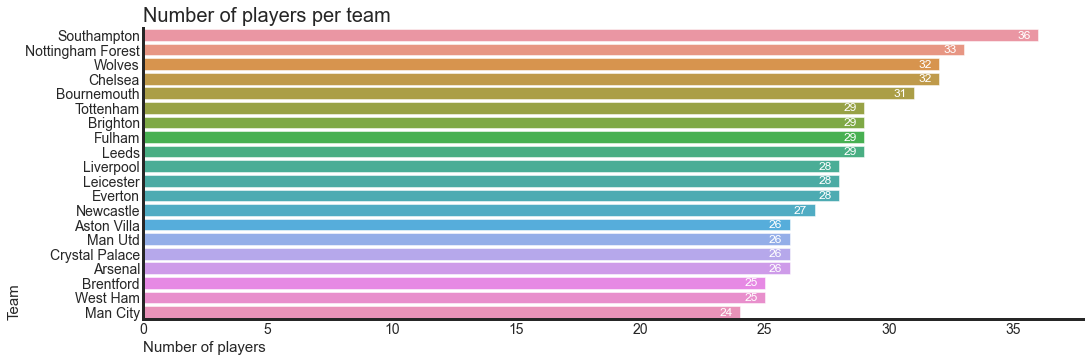

In [520]:
df_players_per_team = df_summary_prepro.groupby("team").count().reset_index()

sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(15, 5))

df_players_per_team_plot = sns.barplot(data=df_players_per_team.sort_values('age', 
                              ascending=False), y="team", x="age", ax=ax)

for p in df_players_per_team_plot.patches:
    df_players_per_team_plot.annotate(f'{int(p.get_width())}', 
                                     (p.get_x() + p.get_width() - 0.3, p.get_y() + p.get_height()- 0.05),
                ha='right', va='center', fontsize=12, color='white', xytext=(0, 5),
                textcoords='offset points')

df_players_per_team_plot.set_ylabel('Team', loc="bottom", fontsize=15)
df_players_per_team_plot.set_xlabel('Number of players', loc="left", fontsize=15)
df_players_per_team_plot.set_title('Number of players per team', loc="left", fontsize=20)
sns.despine()

Southampton is the team with more players with 36, Manchester City has 24 players and it is the team with less players.

Let's see now the percetange of players in each position per team.

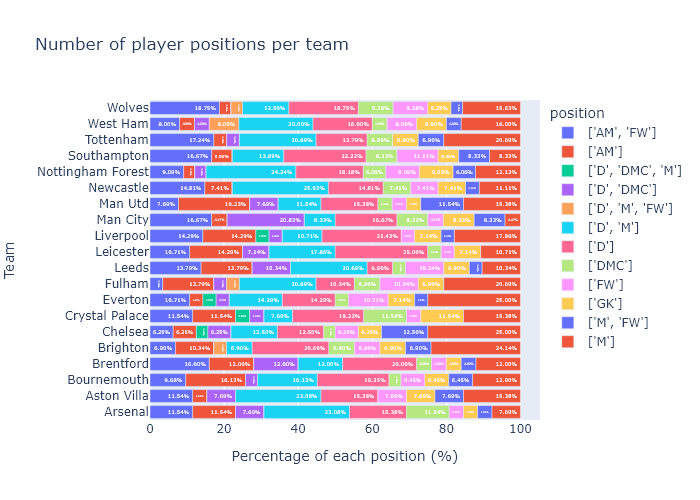

In [5]:
df_position_per_team = df_summary_prepro.explode("position")
df_position_per_team = df_position_per_team.groupby(["team",'position']).count().reset_index()
df_position_per_team['percentage'] = df_position_per_team.groupby('team')['player_id'].transform(
                                                                lambda x: x / x.sum() * 100)

df_position_per_team = df_position_per_team.pivot_table(index='team', columns='position', 
                                                        values='percentage', fill_value=0)

fig = px.bar(df_position_per_team, x=df_position_per_team.columns,
             title='Number of player positions per team', orientation='h')

fig.update_traces(texttemplate='%{x:.2f}%', textposition='inside',  textfont_color="white")
fig.update_xaxes(title_text='Percentage of each position (%)')
fig.update_yaxes(title_text='Team')
fig.show("png")

From above we can say that Manchester City is one of the team with less percentage of Midfielders, just 13.61%, and with the less number of Attacking Midfielders with 13.51%. But it is the team with most number of Defenders and Defensive Midfielder.

All have similar number of Goalkeepers.

## Clustering with players

Clustering method is an unsupervised machine learning technique. It is a set of techniques used to split the data into groups (clusters). These are defined as groups of data that are more similar to other objects in their cluster than they are to data in other clusters. It can be used for customer segmentation.

There are many algorithms to apply clustering such as K-means, DBSCAN and Hierarchical clustering. In this case I use K-means.

### Offensive Players

I will start with the offensive data, by paying attention only to the shots and goals per match.

In [2]:
df_offensive_prepro = pd.read_csv('premier_offensive.csv')

In [3]:
df_offensive_cluster = df_offensive_prepro.copy()

Most of the stats are per match, except the goals. So will I will create a new feature to get the goals per match.

In [4]:
df_offensive_cluster['goals_match'] = df_offensive_cluster.apply(
    lambda row : row["goals"] / (row['appearances'] + row['sub']), axis=1)

Also I will take the players that play only in offensive positions, such as FW and AM.

In [5]:
df_offensive_cluster = df_offensive_cluster[df_offensive_cluster['position'].apply(
    lambda x: ('FW' in x) | ('AM' in x))]
df_offensive_cluster_label = df_offensive_cluster.copy() 

In [6]:
df_offensive_cluster = df_offensive_cluster[['goals_match', 'shots']]

In [7]:
scaler = StandardScaler()
scalled_offensive_cluster = scaler.fit_transform(df_offensive_cluster)

I will use the Elbow method to find the K value.

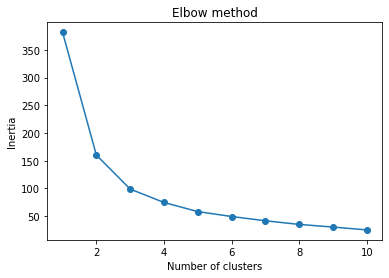

In [8]:
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(scalled_offensive_cluster)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show() 

Sometimes is hard to choose the point of the curve, we can use kneed to confirm it programmatically.

In [9]:
kneed = KneeLocator(range(1, 11), inertias, curve="convex", direction="decreasing")
kneed.elbow

3

Based on these both, I will use 3 as K value.

In [20]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(scalled_offensive_cluster)
kmeans.labels_

array([2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 1, 2, 1, 2, 0, 1, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0,
       1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 1, 0, 2, 1, 0, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2,
       0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0,
       2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [21]:
df_offensive_cluster_label['cluster'] = kmeans.labels_

Let's see the cluster distribution in a plot.

In [22]:
fig = px.scatter(df_offensive_cluster_label, x='shots', y='goals_match', color='cluster', 
                 hover_name=df_offensive_cluster_label['player_name'])
fig.show()

We can see how the players of cluster 0 and 2 are more close to each other. In case of the cluster 1, the players are more dispersed, where the most isolated player is Erling Haaland.

Let's see each cluster, starting by the cluster 1.

In [41]:
df_offensive_cluster1 = df_offensive_cluster_label[df_offensive_cluster_label['cluster'] == 1]

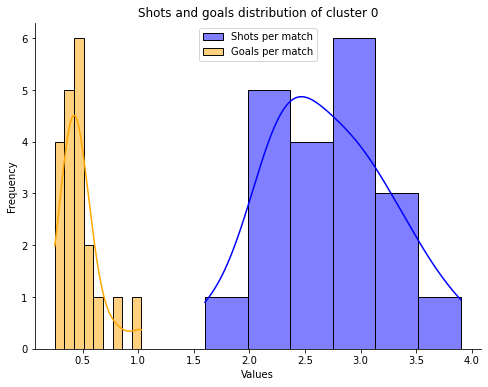

In [42]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df_offensive_cluster1['shots'], kde=True, color='blue', label='Shots per match')
sns.histplot(data=df_offensive_cluster1['goals_match'], kde=True, color='orange', 
             label='Goals per match')
sns.despine()
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Shots and goals distribution of cluster 0')
plt.legend()
plt.show()

In [43]:
df_offensive_cluster1[['shots', 'goals_match']].describe()

,shots,goals_match
count,20.00000,20.000000
mean,2.70500,0.476875
std,0.55864,0.179213
min,1.60000,0.250000
25%,2.30000,0.399642
50%,2.65000,0.430288
75%,3.02500,0.520161
max,3.90000,1.028571


The distribution of the shots looks like a normal distribution. The distribution of the goals per match is a bit right skewed, it means that we have some outliers in the maximum values. We can confirm that with a boxplot.

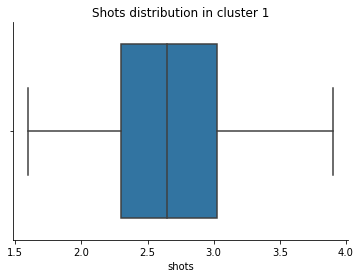

In [44]:
cluster1_shots = sns.boxplot(data=df_offensive_cluster1, x ='shots')
cluster1_shots.set_title('Shots distribution in cluster 1')
sns.despine()

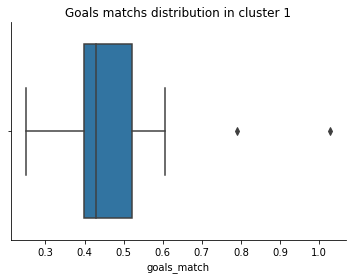

In [45]:
cluster1_goals_match = sns.boxplot(data=df_offensive_cluster1, x ='goals_match')
cluster1_goals_match.set_title('Goals matchs distribution in cluster 1')
sns.despine()

In this cluster we have just 20 players. Tha max shot per game is 4, and the max goal per game is 1. In the boxplot we can see that the shots are well spread, but in the goals boxplot the distribution is narrow and we can see two outliers.

In [48]:
df_offensive_cluster1[df_offensive_cluster1['cluster'] == 1][['player_name', 'shots', 'goals_match']]

,player_name,shots,goals_match
3,Erling Haaland,3.5,1.028571
4,Harry Kane,3.4,0.789474
6,Gabriel Jesus,3.0,0.423077
11,Martin Ødegaard,2.5,0.405405
13,Gabriel Martinelli,2.2,0.416667
14,Ivan Toney,2.8,0.606061
16,James Maddison,2.8,0.333333
20,Mohamed Salah,3.3,0.500000
25,Aleksandar Mitrovic,3.9,0.583333
26,Marcus Rashford,3.1,0.485714


Here we can see our outliers, Erling Haaland and Harry Kane.

Let's see the cluster 0.

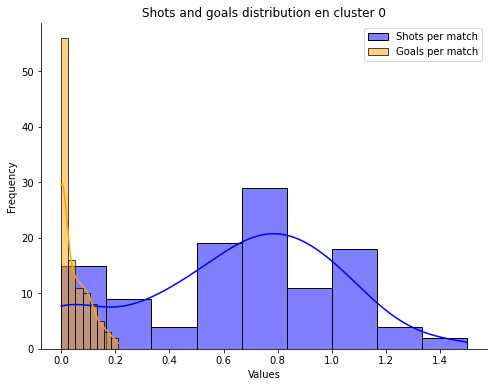

In [58]:
df_offensive_cluster0 = df_offensive_cluster_label[df_offensive_cluster_label['cluster'] == 0]
plt.figure(figsize=(8, 6))
sns.histplot(data=df_offensive_cluster0['shots'], kde=True, color='blue', label='Shots per match')
sns.histplot(data=df_offensive_cluster0['goals_match'], kde=True, color='orange', 
             label='Goals per match')
sns.despine()
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Shots and goals distribution en cluster 0')
plt.legend()
plt.show()

The distribution of the goals will be always right skewed.

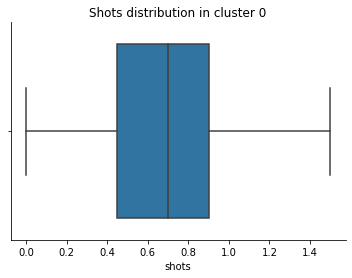

In [33]:
cluster0_shots = sns.boxplot(data=df_offensive_cluster0, x ='shots')
cluster0_shots.set_title('Shots distribution in cluster 0')
sns.despine()

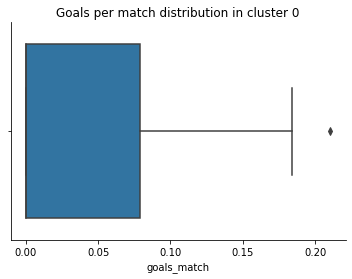

In [34]:
cluster0_goals_match = sns.boxplot(data=df_offensive_cluster0, x ='goals_match')
cluster0_goals_match.set_title('Goals per match distribution in cluster 0')
sns.despine()

In [73]:
df_offensive_cluster0[['shots', 'goals_match']].describe()

,shots,goals_match
count,111.000000,111.000000
mean,0.654955,0.043093
std,0.360993,0.054072
min,0.000000,0.000000
25%,0.450000,0.000000
50%,0.700000,0.000000
75%,0.900000,0.079002
max,1.500000,0.210526


In [38]:
df_offensive_cluster0.head(5)

,Unnamed: 0,player_id,player_name,team,specific_position,age,appearances,sub,minutes,goals,...,key_passes,dribbles,fouls,offsides,dispossessed,bad_control,rating,position,goals_match,cluster
83,83,84,Jacob Ramsey,Aston Villa,['AM(CLR)'],22,31,4,2647,6,...,1.2,0.9,1.3,0.1,1.1,1.8,6.86,['AM'],0.171429,0
86,86,87,Leandro Trossard,Arsenal,"['M(CLR)', 'FW']",28,10,10,930,1,...,1.2,0.8,0.9,0.2,1.2,0.9,6.84,"['M', 'FW']",0.050000,0
103,103,104,Bernardo Silva,Man City,"['M(CLR)', 'FW']",29,24,10,2203,4,...,0.9,0.8,0.4,0.1,0.9,0.9,6.80,"['M', 'FW']",0.117647,0
105,105,106,Allan Saint-Maximin,Newcastle,"['AM(CLR)', 'FW']",26,12,13,1119,1,...,1.2,2.3,0.6,0.1,1.2,1.2,6.80,"['AM', 'FW']",0.040000,0
106,106,107,Noni Madueke,Chelsea,"['AM(R)', 'FW']",21,7,5,646,1,...,1.1,2.8,1.3,0.2,1.1,1.4,6.80,"['AM', 'FW']",0.083333,0


In this case we have much more players than before. In this cluster, unlike the cluster 1, we have players without shots. Also the max value of shots is less than the min value of shots in cluster 1.

In ths cluster we have a very low rate of goals per match and shots, bellow the mean of all the players.

Her we have player like Bernardo Silva (Manchester City) and Jacob Ramsey (Aston Villa).

Let's check the last cluster.

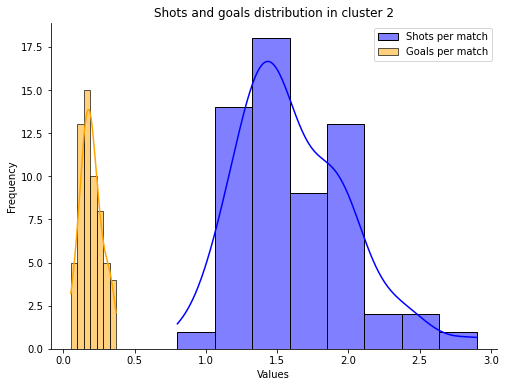

In [35]:
df_offensive_cluster2 = df_offensive_cluster_label[df_offensive_cluster_label['cluster'] == 2]
plt.figure(figsize=(8, 6))
sns.histplot(data=df_offensive_cluster2['shots'], kde=True, color='blue', label='Shots per match')
sns.histplot(data=df_offensive_cluster2['goals_match'], kde=True, color='orange', 
             label='Goals per match')
sns.despine()
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Shots and goals distribution in cluster 2')
plt.legend()
plt.show()

In this cluster the distributions don't look skewed.

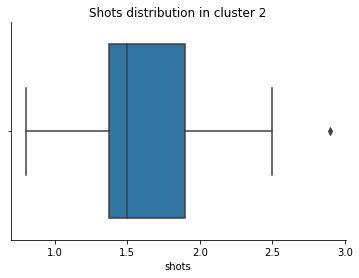

In [36]:
cluster2_shots = sns.boxplot(data=df_offensive_cluster2, x ='shots')
cluster2_shots.set_title('Shots distribution in cluster 2')
sns.despine()

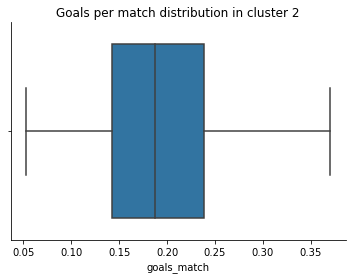

In [37]:
cluster2_shots = sns.boxplot(data=df_offensive_cluster2, x ='goals_match')
cluster2_shots.set_title('Goals per match distribution in cluster 2')
sns.despine()

In [78]:
df_offensive_cluster2[['shots', 'goals_match']].describe()

,shots,goals_match
count,60.000000,60.000000
mean,1.616667,0.194404
std,0.394525,0.076114
min,0.800000,0.052632
25%,1.375000,0.142857
50%,1.500000,0.187500
75%,1.900000,0.238442
max,2.900000,0.370370


In [39]:
df_offensive_cluster2.head()

,Unnamed: 0,player_id,player_name,team,specific_position,age,appearances,sub,minutes,goals,...,key_passes,dribbles,fouls,offsides,dispossessed,bad_control,rating,position,goals_match,cluster
1,1,2,Kevin De Bruyne,Man City,"['M(CLR)', 'FW']",32,28,4,2425,7,...,3.1,1.0,0.9,0.2,0.9,1.3,7.58,"['M', 'FW']",0.218750,2
10,10,11,Jack Grealish,Man City,"['AM(CL)', 'FW']",28,23,5,2064,5,...,1.8,1.6,2.8,0.1,1.0,1.3,7.33,"['AM', 'FW']",0.178571,2
15,15,16,Joelinton,Newcastle,"['AM(CLR)', 'FW']",27,30,2,2664,6,...,0.8,1.7,1.1,0.0,1.6,2.3,7.24,"['AM', 'FW']",0.187500,2
21,21,22,Phil Foden,Man City,"['AM(CLR)', 'FW']",23,22,10,1844,11,...,1.3,1.3,0.9,0.2,0.9,1.1,7.13,"['AM', 'FW']",0.343750,2
30,30,31,Cody Gakpo,Liverpool,"['AM(CL)', 'FW']",24,17,4,1465,7,...,1.1,1.1,1.6,0.4,1.7,2.0,7.06,"['AM', 'FW']",0.333333,2


We have 60 players, less than cluster 1 but with better stats. These players have as maximum the double of the cluster 0. An here there is not a player without shots.

Here we have player like Kevin De Bruyne and Jack Grealish, both from Manchester City.

To summarize...

In [53]:
df_offensive_cluster_label[['goals_match', 'shots']].describe()

,goals_match,shots
count,191.000000,191.000000
mean,0.136047,1.171728
std,0.158286,0.788027
min,0.000000,0.000000
25%,0.000000,0.700000
50%,0.100000,1.000000
75%,0.190524,1.500000
max,1.028571,3.900000


In [49]:
df_offensive_cluster_mean = df_offensive_cluster_label[['goals_match', 'shots', 'cluster'
                                                       ]].groupby('cluster').mean()
df_offensive_cluster_mean.head()

,goals_match,shots
cluster,,
0,0.043093,0.654955
1,0.476875,2.705000
2,0.194404,1.616667


* In the cluster 1 we have the best Forwards, with the highest number of shots and goals per match and it is the cluster with less number of players. Their players are over the mean of all the players. Tha max values are here.
* In the cluster 0, that contains the most number of players,  we can find the worst Forwards and  players without shots. The shots and goals are under the mean of all the players.
* In the cluster 2 there are players with good stats, much better than the cluster 0. Their statistics are close to the mean of all the players.

Let's see the number of players of each cluster per team.

In [61]:
df_offensive_cluster_team =  df_offensive_cluster_label.groupby(['team', 
                                                                 'cluster']).count().reset_index()

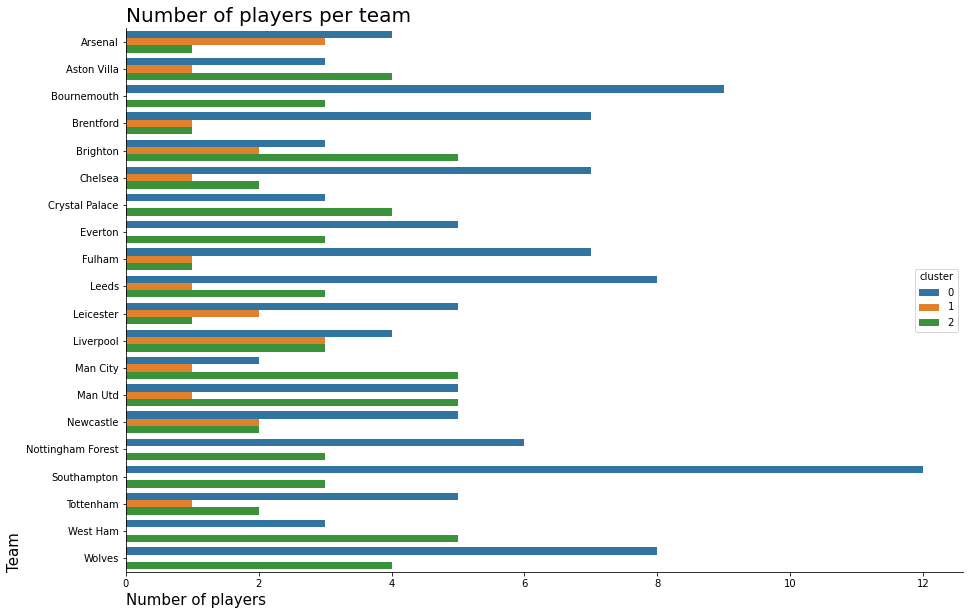

In [62]:
fig, ax = plt.subplots(figsize=(15, 10))
players_clusters_teams = sns.barplot(data=df_offensive_cluster_team, y="team", x="age", 
                                     hue='cluster',ax =ax)

players_clusters_teams.set_ylabel('Team', loc="bottom", fontsize=15)
players_clusters_teams.set_xlabel('Number of players', loc="left", fontsize=15)
players_clusters_teams.set_title('Number of players per team', loc="left", fontsize=20)
sns.despine()

Most of the teams have players that belong to the cluster 0 (the worst one), specially Southampton.

The team that has more number of players of the cluster 1 is Liverpool, but this team has more players of the cluster 0.

Manchester City is the team with less number of players from the cluster 0. It has the best player of the cluster 1 and many players of the cluster 2. So we can say that Manchester City is the team with the best Forwards.

------------------------

### Defensive Players

In [63]:
df_defensive_prepro = pd.read_csv('premier_defensive.csv')

Now I will analyse the defense.

In [64]:
df_defensive_cluster = df_defensive_prepro.copy()
df_defensive_cluster = df_defensive_cluster[df_defensive_cluster['position'].apply(
    lambda x: ('D' in x) | ('DMC' in x))]
df_defensive_cluster_label = df_defensive_cluster.copy() 

For this analysis I will take these features:
- tackles
- interceptions
- clearances
- outfielder_blocks

In [65]:
df_defensive_cluster = df_defensive_cluster[['tackles', 'interceptions', 'clearances',
                                             'outfielder_blocks']]

In [66]:
df_defensive_scaled_features = scaler.fit_transform(df_defensive_cluster)

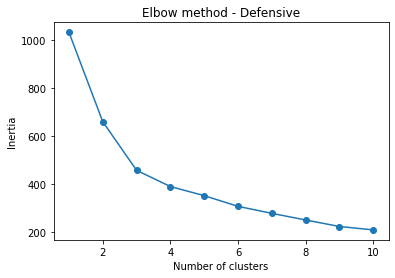

In [67]:
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df_defensive_scaled_features)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method - Defensive')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show() 

In [68]:
kl = KneeLocator(range(1, 11), inertias, curve="convex", direction="decreasing")
kl.elbow

3

Here we have 3 clusters also.

In [69]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_defensive_scaled_features)
kmeans.labels_

array([0, 2, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 2, 0, 1, 2, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 1, 1, 1, 2, 1, 2, 0,
       0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 1, 1, 2, 0, 0, 0, 2, 0,
       1, 2, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0,
       0, 1, 1, 2, 2, 1, 1, 0, 1, 2, 2, 0, 1, 2, 1, 2, 2, 2, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 1,
       0, 1, 1, 1, 1, 0, 2, 2, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2,
       1, 1, 2, 1, 1, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 1, 2, 2, 2, 2, 0, 2,
       1, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2,
       1, 1, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [70]:
df_defensive_cluster_label['cluster'] = kmeans.labels_

In [131]:
df_defensive_cluster_label[['tackles', 'interceptions', 'clearances',
                                        'outfielder_blocks']].describe()

,tackles,interceptions,clearances,outfielder_blocks
count,258.000000,258.000000,258.000000,258.000000
mean,1.349225,0.831008,1.932558,0.364341
std,0.775362,0.521342,1.384610,0.322393
min,0.000000,0.000000,0.000000,0.000000
25%,0.900000,0.500000,0.800000,0.100000
50%,1.300000,0.800000,1.700000,0.300000
75%,1.800000,1.175000,2.800000,0.500000
max,5.000000,4.500000,7.100000,2.100000


Let's take a look at the tackles.

##### Tackles

In [95]:
df_defensive_cluster_label.groupby('cluster')['tackles'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,90.0,2.056667,0.670577,1.0,1.625,2.0,2.3,5.0
1,59.0,1.227119,0.501319,0.4,0.900,1.2,1.5,2.6
2,109.0,0.831193,0.478558,0.0,0.500,0.9,1.2,1.7


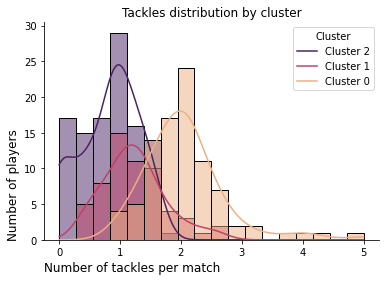

In [117]:
cluster_tackles_plot = sns.histplot(data=df_defensive_cluster_label, x='tackles', kde=True,hue='cluster', 
             label='Shots per match', palette='flare')
cluster_tackles_plot.set_title('Tackles distribution by cluster')
cluster_tackles_plot.set_xlabel('Number of tackles per match', fontsize=12, loc="left")
cluster_tackles_plot.set_ylabel('Number of players', fontsize=12, loc="bottom")
custom_legend_labels = ['Cluster 2', 'Cluster 1', 'Cluster 0']
cluster_tackles_plot.legend(title='Cluster', labels=custom_legend_labels)
sns.despine()

About the tackles, we see that the cluster 0 is well spread, with 2 tackles per match as a median (over the mean of the defenders), minimum 1 and maximum 5 tackles. It is the cluster with more tackles per match. 90 players belong to this cluster.

The cluster with less players is the cluster 1. It has 59 players, where each one has a mean of 1.2 tackles per match (close to the mean of the defenders), and maximum 2.6.

The cluster with more players is the cluster 2. Its distribution is more narrow than the cluster 0, and the players have 0.83 tackles per match (bellow the mean of the defenders). This is the cluster with less tackles.

-------------------

##### Interceptions

In [118]:
df_defensive_cluster_label.groupby('cluster')['interceptions'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,90.0,1.140000,0.496007,0.3,0.80,1.1,1.3,4.5
1,59.0,1.101695,0.386180,0.4,0.85,1.1,1.3,2.5
2,109.0,0.429358,0.285548,0.0,0.20,0.4,0.6,1.0


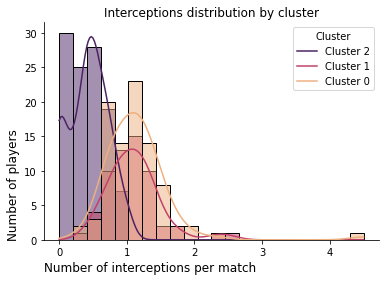

In [120]:
cluster_interceptions_plot = sns.histplot(data=df_defensive_cluster_label, x='interceptions', 
            kde=True,hue='cluster', label='Interceptions per match', palette='flare')
cluster_interceptions_plot.set_title('Interceptions distribution by cluster')
cluster_interceptions_plot.set_xlabel('Number of interceptions per match', fontsize=12, loc="left")
cluster_interceptions_plot.set_ylabel('Number of players', fontsize=12, loc="bottom")
custom_legend_labels = ['Cluster 2', 'Cluster 1', 'Cluster 0']
cluster_interceptions_plot.legend(title='Cluster', labels=custom_legend_labels)
sns.despine()

About the interceptions, the cluster 0 and 1 are very similar, both have same mean of interceptions per match with 1 (over the mean of the defenders).

In the cluster 2 we have the half of interceptions than the other clusters (bellow the mean of the defenders)

-------------

##### Clearances

In [121]:
df_defensive_cluster_label.groupby('cluster')['clearances'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,90.0,1.808889,0.694221,0.3,1.225,1.8,2.2,3.3
1,59.0,3.928814,0.950871,1.9,3.300,3.8,4.4,7.1
2,109.0,0.954128,0.723486,0.0,0.500,0.8,1.4,3.2


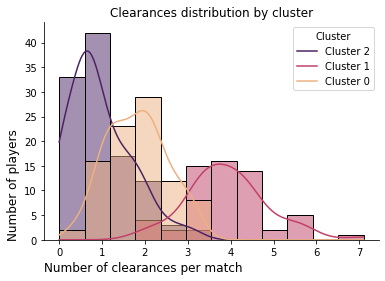

In [123]:
cluster_clearances_plot = sns.histplot(data=df_defensive_cluster_label, x='clearances', 
            kde=True, hue='cluster', label='Clearances per match', palette='flare')
cluster_clearances_plot.set_title('Clearances distribution by cluster')
cluster_clearances_plot.set_xlabel('Number of clearances per match', fontsize=12, loc="left")
cluster_clearances_plot.set_ylabel('Number of players', fontsize=12, loc="bottom")
custom_legend_labels = ['Cluster 2', 'Cluster 1', 'Cluster 0']
cluster_clearances_plot.legend(title='Cluster', labels=custom_legend_labels)
sns.despine()

In cluster 0 there are players that have a mean of 1.8 clearances per match.

Cluster 1 is the cluster with the least number of players, but with the most number of clearences per match with a mean of 4 (over the mean of the defenders), and mininum 2. Looking that the standard deviation we can say the distribution is well spread.

The cluster 2 contains the most number of players with 109, they have a mean of 0.95 (bellow the mean of the defenders) clearances per match. Also, we have players without clearances.

---------------------

##### Outfielder Blocks

In [127]:
df_defensive_cluster_label.groupby('cluster')['outfielder_blocks'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,90.0,0.312222,0.152011,0.0,0.2,0.3,0.4,0.7
1,59.0,0.811864,0.304044,0.4,0.6,0.7,1.0,2.1
2,109.0,0.165138,0.164078,0.0,0.0,0.1,0.3,0.7


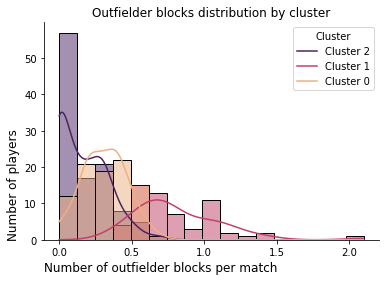

In [126]:
outfielder_blocks_plot = sns.histplot(data=df_defensive_cluster_label, x='outfielder_blocks', 
            kde=True, hue='cluster', label='Outfielder blocks per match', palette='flare')
outfielder_blocks_plot.set_title('Outfielder blocks distribution by cluster')
outfielder_blocks_plot.set_xlabel('Number of outfielder blocks per match', fontsize=12, loc="left")
outfielder_blocks_plot.set_ylabel('Number of players', fontsize=12, loc="bottom")
custom_legend_labels = ['Cluster 2', 'Cluster 1', 'Cluster 0']
outfielder_blocks_plot.legend(title='Cluster', labels=custom_legend_labels)
sns.despine()

In [94]:
df_defensive_cluster_label.groupby('cluster')['outfielder_blocks'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,90.0,0.312222,0.152011,0.0,0.2,0.3,0.4,0.7
1,59.0,0.811864,0.304044,0.4,0.6,0.7,1.0,2.1
2,109.0,0.165138,0.164078,0.0,0.0,0.1,0.3,0.7


In this case the clusters 0 and 2 are very similar, but in cluster 2 we have many players with zero outfielder blocks and the half of mean of outfielder blocks per match with 0.16 (bellow the mean of the defenders).

In cluster 1 we have less players but more outfielder blocks with a mean of 0.81 per match. Its dribution is spread. Is the cluster with more number of outfielder blocks.

To summarize...

In [128]:
df_defensive_cluster_mean = df_defensive_cluster_label[['tackles', 'interceptions', 'clearances',
                                        'outfielder_blocks', 'cluster']].groupby('cluster').mean()
df_defensive_cluster_mean.head()

,tackles,interceptions,clearances,outfielder_blocks
cluster,,,,
0,2.056667,1.140000,1.808889,0.312222
1,1.227119,1.101695,3.928814,0.811864
2,0.831193,0.429358,0.954128,0.165138


- Cluster 0: Most number of tackles, 2 per match. One interception per match. A mean of 1.8 clearances and a mean of 0.31 outfielder blocks per match (High number of tackles and interceptions)
- Cluster 1: Mean of 1.2 tackles per match. One interception per match. High number of clearances with 4 per match, highest outfielder blocks with a mean of 0.81.(High number of clearances and outfielder blocks)
- Cluster 2: Least tackles and interceptions per match. Players here have a mean of 0.95 clearances per match and few number of outfielder blocks (Low values in all the stats).

Let's see the number of players in each cluster per team.

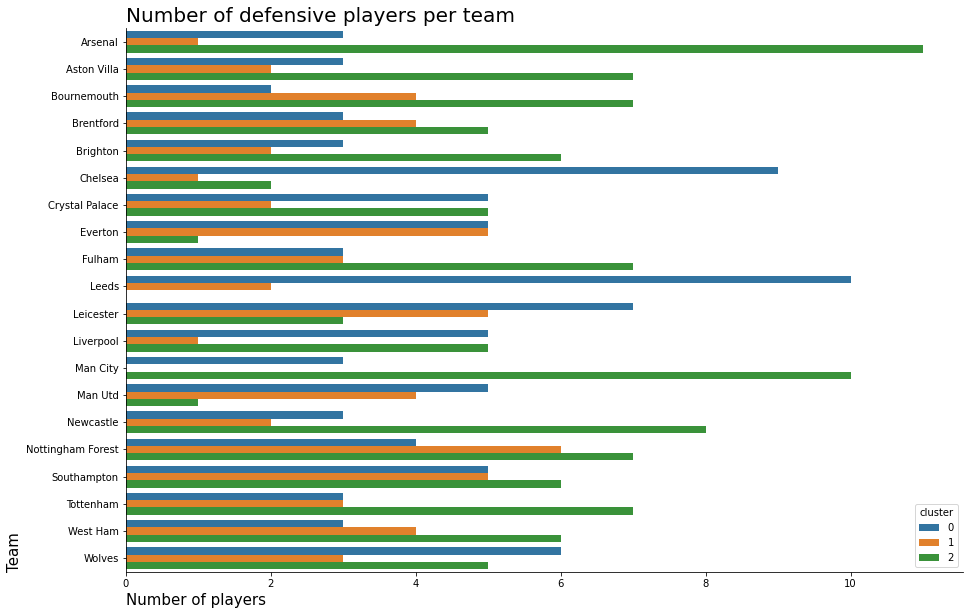

In [129]:
defensive_cluster_team = df_defensive_cluster_label.groupby(['team', 'cluster']).count().reset_index()
fig, ax = plt.subplots(figsize=(15, 10))
players_clusters_teams = sns.barplot(data=defensive_cluster_team, y="team", x="age", 
                                     hue='cluster',ax =ax)
players_clusters_teams.set_ylabel('Team', loc="bottom", fontsize=15)
players_clusters_teams.set_xlabel('Number of players', loc="left", fontsize=15)
players_clusters_teams.set_title('Number of defensive players per team', loc="left", fontsize=20)
sns.despine()

Manchester City and Arsenal are the teams that has most number of players of number 2.

Leeds is the team with most players from cluster 0. And Nottingham Forest the same in cluster 1.

## Conclusion

Looking that the type of players that of the teams we can guess how the team plays.

For example Manchester city, this team has the best forwards, defenders with least tackles and cleareas. We can say that the team may prioritize ball possession (is the team with the highest possession) and a style of playing that involves controlling the game through passing and positioning. Rather than frequently engaging in defensive challenges, they may focus on maintaining possession and controlling the tempo of the match. The low numbers in defensive stats could also indicate that the team is often in control of the match, spending more time in the opponent's half and focusing on offensive play (with the best forwards). A dominant attacking performance might contribute to fewer defensive actions being required.

In contrast, Leeds and Nottingham Forest have a very high number in defensive stats and a poor percentage of possession. Also they have many yellow cards.

A part of understand the style of playing of the teams, we can use clustering in the season pass in order to buy players with similar stats but with a lower price than a famous player.